## 环境准备

In [1]:
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

Using TensorFlow backend.


2.3.1
2.1.0


## MNIST 手写字体识别【多分类】尝试

In [2]:
from keras import layers
from keras import models

model = models.Sequential()
# 定义一个卷积输入层，卷积核是3*3，共32个，输入是(28, 28, 1)，输出是(26, 26, 32)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# 定义一个2*2的池化层
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# 将所有的输出展平
model.add(layers.Flatten())
# 定义一个全连接层，有64个神经元
model.add(layers.Dense(64, activation='relu'))
# 多分类问题，将输出在每个分类上的概率
model.add(layers.Dense(10, activation='softmax'))

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [4]:
# 加载数据开始训练
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print('train data:', train_images.shape, train_labels.shape)
print('test data:', test_images.shape, test_labels.shape)

train data: (60000, 28, 28, 1) (60000, 10)
test data: (10000, 28, 28, 1) (10000, 10)


In [5]:
# 训练数据准确的已经优于全连接网络
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_loss, test_acc)

Epoch 1/5
60000/60000 [==============================] - 23s 385us/step - loss: 0.1802 - accuracy: 0.9437
Epoch 2/5
60000/60000 [==============================] - 23s 382us/step - loss: 0.0479 - accuracy: 0.9849
Epoch 3/5
60000/60000 [==============================] - 23s 384us/step - loss: 0.0332 - accuracy: 0.9900
Epoch 4/5
60000/60000 [==============================] - 23s 380us/step - loss: 0.0245 - accuracy: 0.9925
Epoch 5/5
10000/10000 [==============================] - 1s 106us/step
0.02494697037681035 0.9923999905586243


## 猫狗分类

数据下载：https://www.kaggle.com/c/dogs-vs-cats/data  
源数据： 2000 张猫的图像 + 2000 张狗的图像  
数据划分： 2000 张训练，1000 张验证，1000张测试  
实践流程：训练一个无任何优化的基准版本（准确度70%） --> 加入了数据增强的版本（准确度81%） --> 用预训练好的网络（准确度89%） --> 数据增强+预训练好的网络（准确度90%） --> 微调后的网络（准确度9%）  
简而言之，越来越耗时，越来越准

### 加载数据

目录结构：  
cat-dog-small  
├─test  
│  ├─cats 500张   
│  └─dogs 500张  
├─train  
│  ├─cats 1000张  
│  └─dogs 1000张  
└─validation  
    ├─cats 500张  
    └─dogs 500张  

In [18]:
import os, shutil
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = 'D://Kaggle//cat-dog//train'

# The directory where we will
# store our smaller dataset
base_dir = 'D://Kaggle//cat-dog-small'
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [16]:
os.mkdir(base_dir)

# Directories for our training splits
os.mkdir(train_dir)
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directories for our validation splits
os.mkdir(validation_dir)
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directories for our test splits
os.mkdir(test_dir)
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)


### 数据处理
基本步骤：  
(1) 读取图像文件  
(2) 将 JPEG 文件解码为 RGB 像素网格  
(3) 将这些像素网格转换为浮点数张量，并归一化到[0, 1]

ImageDataGenerator图像生成器，一步搞定

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 分批次的将数据按目录读取出来
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
i = 1
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    i+=1
    if i > 3:
        break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)
data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)
data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [13]:
import matplotlib.pyplot as plt

# 创建一个画图的工具函数
def plot_acc_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### 构建基准网络（acc 0.700）

In [9]:
from keras import layers
from keras import models

model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

这里我们来仔细介绍一下param参数的计算
- 全连接网络  
total_params = (input_data_channels + 1) * number_of_filters     
参数的总量等于一个神经元的参数量（W,b）乘上神经元个数  
dense_5 (Dense):(512, input_shape=(6272), output_shape=(None, 512))  
    &emsp;&emsp;params = (6272 + 1) * 522 = 3211776  
dense_6 (Dense):(1, input_shape=(512), output_shape=(None, 1))  
    &emsp;&emsp;params = (512 + 1) * 1 = 513   

- 卷积网络  
total_params = (filter_height * filter_width * input_image_channels + 1) * number_of_filters  
参数的总量等于一个卷积核的参数量（W,b）乘上卷积核的个数  
conv2d_8 (Conv2D):(32, kernel_size=(3, 3), input_shape=(150, 150, 3), output_shape=(None, 148, 148, 32))  
    &emsp;&emsp;params = (3 * 3 * 3 + 1) * 32 = 896  
conv2d_9 (Conv2D):(64, kernel_size=(3, 3), input_shape=(74, 74, 32), output_shape=(None, 72, 72, 64))  
    &emsp;&emsp;params = (3 * 3 * 32 + 1) * 64 = 18496  
conv2d_10 (Conv2D):(128, kernel_size=(3, 3), input_shape=(36, 36, 64), output_shape=(None, 34, 34, 128))  
    &emsp;&emsp;params = (3 * 3 * 64 + 1) * 128 = 73856  
conv2d_11 (Conv2D):(128, kernel_size=(3, 3), input_shape=(17, 17, 128), output_shape=(None, 15, 15, 128))  
    &emsp;&emsp;params = (3 * 3 * 128 + 1) * 128 = 147584  

In [10]:
from keras import optimizers

model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [11]:
history1 = model1.fit_generator(
      train_generator, # 训练数据生成器
      steps_per_epoch=100, # 每一个迭代需要读取100次生成器的数据
      epochs=30, # 迭代次数
      validation_data=validation_generator, # 验证数据生成器
      validation_steps=50) # 需要读取50次才能加载全部的验证集数据

Epoch 1/30
100/100 [==============================] - 40s 397ms/step - loss: 0.6879 - acc: 0.5475 - val_loss: 0.6584 - val_acc: 0.6070
Epoch 2/30
100/100 [==============================] - 39s 391ms/step - loss: 0.6554 - acc: 0.6195 - val_loss: 0.6524 - val_acc: 0.6470
Epoch 3/30
100/100 [==============================] - 39s 389ms/step - loss: 0.6085 - acc: 0.6845 - val_loss: 0.5877 - val_acc: 0.6560
Epoch 4/30
100/100 [==============================] - 38s 383ms/step - loss: 0.5742 - acc: 0.6955 - val_loss: 0.6186 - val_acc: 0.6580
Epoch 5/30
100/100 [==============================] - 40s 398ms/step - loss: 0.5324 - acc: 0.7335 - val_loss: 0.6371 - val_acc: 0.6940
Epoch 6/30
100/100 [==============================] - 39s 389ms/step - loss: 0.5053 - acc: 0.7570 - val_loss: 0.6247 - val_acc: 0.6960
Epoch 7/30
100/100 [==============================] - 39s 387ms/step - loss: 0.4798 - acc: 0.7700 - val_loss: 0.6352 - val_acc: 0.6860
Epoch 8/30
100/100 [==============================] - 3

In [12]:
model1.save('D://tmp//models//cats_and_dogs_small_1.h5')

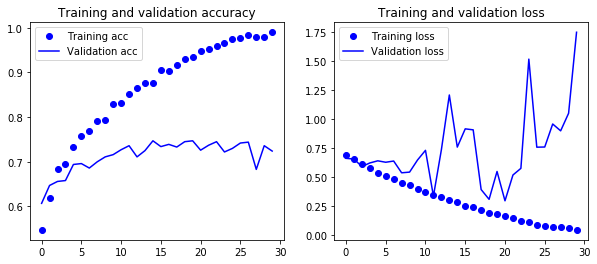

In [14]:
# 训练集准确率一路提升，验证集准确率停滞不前
# 训练集损失直线下跌，验证集损失跌宕攀升
# 典型性过拟合
plot_acc_loss(history1)

In [15]:
# loss的波动幅度有点大
print(model1.metrics_names)
print(model1.evaluate_generator(test_generator, steps=50))

['loss', 'acc']
[0.9294536709785461, 0.699999988079071]


### 构建数据增强的网络（acc 0.810）

In [16]:
# 定义一个图像生成器
datagen = ImageDataGenerator(
      rotation_range=40, # 随机旋转的角度范围
      width_shift_range=0.2, # 在水平方向上平移的范围
      height_shift_range=0.2, # 在垂直方向上平移的范围
      shear_range=0.2, # 随机错切变换的角度
      zoom_range=0.2, # 随机缩放的范围
      horizontal_flip=True,# 随机将一半图像水平翻转
      fill_mode='nearest') # 进行变换时超出边界的点将根据本参数给定的方法('constant', 'earest', 'reflect', 'wrap')进行处理

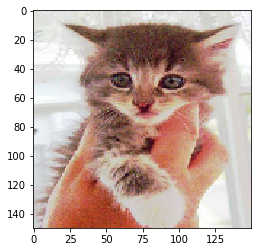

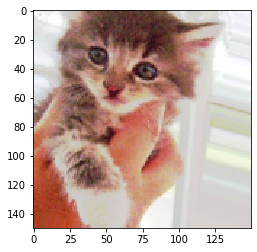

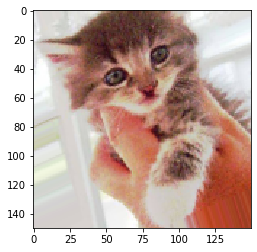

In [19]:
# 选一张图片来实验一下，经过多次运行后发现，额，确实是真随机
from keras.preprocessing import image

# 获得所有图片的绝对路径
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))
plt.figure(0)
plt.imshow(img)
    
# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 1
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
    
plt.show()

In [26]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5)) # 新加了dropout层
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)      

In [27]:
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [28]:
from keras.preprocessing.image import ImageDataGenerator
train_augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
train_augmented_generator = train_augmented_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [31]:
history2 = model2.fit_generator(
      train_augmented_generator,
      steps_per_epoch=100, # 每一批次读取100轮数据，总共是3200张图片
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 59s 586ms/step - loss: 0.6914 - acc: 0.5201 - val_loss: 0.6740 - val_acc: 0.5010
Epoch 2/100
100/100 [==============================] - 57s 575ms/step - loss: 0.6865 - acc: 0.5455 - val_loss: 0.6528 - val_acc: 0.5490
Epoch 3/100
100/100 [==============================] - 58s 583ms/step - loss: 0.6743 - acc: 0.5807 - val_loss: 0.8025 - val_acc: 0.5210
Epoch 4/100
100/100 [==============================] - 57s 569ms/step - loss: 0.6593 - acc: 0.6142 - val_loss: 0.6153 - val_acc: 0.6500
Epoch 5/100
100/100 [==============================] - 58s 581ms/step - loss: 0.6439 - acc: 0.6253 - val_loss: 0.6233 - val_acc: 0.6770
Epoch 6/100
100/100 [==============================] - 59s 595ms/step - loss: 0.6393 - acc: 0.6442 - val_loss: 0.5940 - val_acc: 0.6750
Epoch 7/100
100/100 [==============================] - 57s 571ms/step - loss: 0.6188 - acc: 0.6521 - val_loss: 0.5935 - val_acc: 0.6870
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 57s 569ms/step - loss: 0.4098 - acc: 0.8093 - val_loss: 0.3912 - val_acc: 0.7850
Epoch 62/100
100/100 [==============================] - 57s 572ms/step - loss: 0.4007 - acc: 0.8150 - val_loss: 0.3903 - val_acc: 0.7900
Epoch 63/100
100/100 [==============================] - 57s 568ms/step - loss: 0.4133 - acc: 0.8065 - val_loss: 0.5388 - val_acc: 0.7940
Epoch 64/100
100/100 [==============================] - 57s 569ms/step - loss: 0.4207 - acc: 0.8033 - val_loss: 0.3210 - val_acc: 0.7890
Epoch 65/100
100/100 [==============================] - 57s 572ms/step - loss: 0.4058 - acc: 0.8194 - val_loss: 0.6706 - val_acc: 0.7770
Epoch 66/100
100/100 [==============================] - 57s 571ms/step - loss: 0.3992 - acc: 0.8226 - val_loss: 0.4905 - val_acc: 0.7800
Epoch 67/100
100/100 [==============================] - 58s 583ms/step - loss: 0.3992 - acc: 0.8131 - val_loss: 0.3283 - val_acc: 0.8040
Epoch 68/100
100/100 [===================

In [32]:
model2.save('D://tmp//models//cats_and_dogs_small_2.h5')

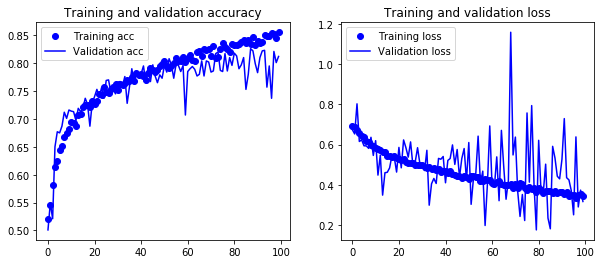

In [33]:
# 准确率不断提升 损失不断降低 还可以更好一点
plot_acc_loss(history2)

In [34]:
print(model2.metrics_names)
print(model2.evaluate_generator(test_generator, steps=50))

['loss', 'acc']
[0.4289940893650055, 0.8100000023841858]


### 使用VGG16网络（固定卷积基）

In [35]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # 指定模型初始化的权重检查点
                  include_top=False, # 模型最后是否包含密集连接分类器，默认有1000个类别
                  input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

固定卷积基也分几种实践策略  
1、直接使用VGG16在原始数据上的输出，单独训练一个分类器  
2、在VGG16网络上新加入全连接层，形成一个完整的端对端的网络  

#### 使用VGG16的输出单独训练分类器（acc 0.893）

In [36]:
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

# 将原始输入、label转换为VGG16的卷积基输出、label
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # 卷积基最后一层的输出为(4， 4， 512)
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [37]:
train_features.shape

(2000, 4, 4, 512)

In [38]:
# 数据降维，准备进入全连接层
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [39]:
from keras import models
from keras import layers
from keras import optimizers

model3 = models.Sequential()
model3.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history3 = model3.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6257 - acc: 0.6430 - val_loss: 0.4463 - val_acc: 0.8390
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4225 - acc: 0.8140 - val_loss: 0.3595 - val_acc: 0.8640
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3538 - acc: 0.8430 - val_loss: 0.3194 - val_acc: 0.8720
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3160 - acc: 0.8755 - val_loss: 0.2988 - val_acc: 0.8910
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2789 - acc: 0.8865 - val_loss: 0.2795 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2628 - acc: 0.8925 - val_loss: 0.2689 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2403 - acc: 0.9055 - val_loss: 0.2687 - val_acc: 0.9000
Epoch 8/30
200

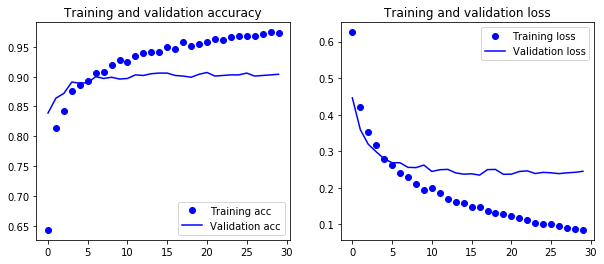

In [40]:
# 还是比较典型的过拟合
plot_acc_loss(history3)

In [41]:
model3.save('D://tmp//models//cats_and_dogs_small_3.h5')
print(model3.metrics_names)
print(model3.evaluate(test_features, test_labels))

['loss', 'acc']
1000/1000 [==============================] - 0s 104us/step
[0.2545376181602478, 0.8930000066757202]


#### 将VGG16作为最终网络的一部分，使用数据增强，相当的耗时耗资源（acc 0.904）

In [42]:
from keras import models
from keras import layers

model4 = models.Sequential()
model4.add(conv_base)
model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))
model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [43]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model4.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [44]:
conv_base.trainable = False

冻结后只有dense_11、dense_12两层可以训练  
每一层主权重矩阵和偏置向量可以训练，所以两层一共是4个权重可以训练  
被冻结的VGG16一共19层，5个block，去掉1个输出层，5个MaxPolling层，剩下13层，(13+2)*2=30

In [45]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model4.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [46]:
model4.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history4 = model4.fit_generator(
      train_augmented_generator,
      steps_per_epoch=100,
      epochs=60,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/60
 - 199s - loss: 0.5945 - acc: 0.6869 - val_loss: 0.4769 - val_acc: 0.8430
Epoch 2/60
 - 198s - loss: 0.4664 - acc: 0.8027 - val_loss: 0.3371 - val_acc: 0.8480
Epoch 3/60
 - 198s - loss: 0.4176 - acc: 0.8134 - val_loss: 0.4851 - val_acc: 0.8870
Epoch 4/60
 - 199s - loss: 0.3905 - acc: 0.8257 - val_loss: 0.1943 - val_acc: 0.8920
Epoch 5/60
 - 197s - loss: 0.3592 - acc: 0.8431 - val_loss: 0.1643 - val_acc: 0.8950
Epoch 6/60
 - 198s - loss: 0.3501 - acc: 0.8450 - val_loss: 0.2259 - val_acc: 0.8950
Epoch 7/60
 - 198s - loss: 0.3415 - acc: 0.8479 - val_loss: 0.1998 - val_acc: 0.9020
Epoch 8/60
 - 200s - loss: 0.3300 - acc: 0.8618 - val_loss: 0.4336 - val_acc: 0.8830
Epoch 9/60
 - 201s - loss: 0.3469 - acc: 0.8445 - val_loss: 0.2793 - val_acc: 0.8910
Epoch 10/60
 - 203s - loss: 0.3232 - acc: 0.8615 - val_loss: 0.2256 - val_acc: 0.8940
Epoch 11/60
 - 197s - loss: 0.3175 - acc: 0.8598 - val_loss: 0.2909 - val_acc: 0.9060
Epoch 12/60
 - 199s - loss: 0.3192 - acc: 0.8574 - val_loss: 0.

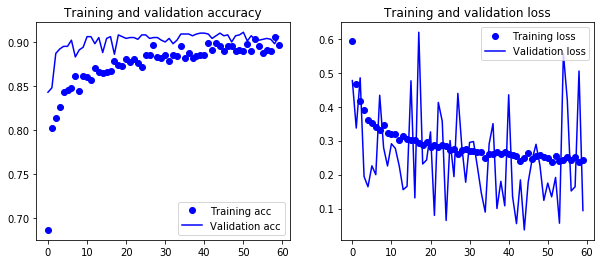

In [47]:
# 高位还可以
plot_acc_loss(history4)

In [48]:
model4.save('D://tmp//models//cats_and_dogs_small_4.h5')
print(model4.metrics_names)
print(model4.evaluate_generator(test_generator, steps=50))

['loss', 'acc']
[0.23142974078655243, 0.9049999713897705]


### 使用VGG16网络，微调（acc 0.924）
![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [52]:
from keras import models
from keras import layers

model5 = models.Sequential()
model5.add(conv_base)
model5.add(layers.Flatten())
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))
model5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [53]:
# 将block5解放
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [54]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model4.trainable_weights))

This is the number of trainable weights before freezing the conv base: 10


In [55]:
model5.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history5 = model5.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 172s 2s/step - loss: 0.4193 - acc: 0.8130 - val_loss: 0.3722 - val_acc: 0.8850
Epoch 2/100
100/100 [==============================] - 172s 2s/step - loss: 0.2055 - acc: 0.9240 - val_loss: 0.2262 - val_acc: 0.9130
Epoch 3/100
100/100 [==============================] - 173s 2s/step - loss: 0.1339 - acc: 0.9555 - val_loss: 0.1674 - val_acc: 0.9130
Epoch 4/100
100/100 [==============================] - 172s 2s/step - loss: 0.0922 - acc: 0.9715 - val_loss: 0.2753 - val_acc: 0.9120
Epoch 5/100
100/100 [==============================] - 172s 2s/step - loss: 0.0591 - acc: 0.9840 - val_loss: 0.2029 - val_acc: 0.9160
Epoch 6/100
100/100 [==============================] - 171s 2s/step - loss: 0.0349 - acc: 0.9950 - val_loss: 0.1432 - val_acc: 0.9280
Epoch 7/100
100/100 [==============================] - 171s 2s/step - loss: 0.0213 - acc: 0.9980 - val_loss: 0.2696 - val_acc: 0.9130
Epoch 8/100
100/100 [==============================] - 171s 2s

100/100 [==============================] - 173s 2s/step - loss: 4.4439e-09 - acc: 1.0000 - val_loss: 0.4456 - val_acc: 0.9340
Epoch 61/100
100/100 [==============================] - 173s 2s/step - loss: 4.3074e-09 - acc: 1.0000 - val_loss: 0.0304 - val_acc: 0.9340
Epoch 62/100
100/100 [==============================] - 172s 2s/step - loss: 4.1729e-09 - acc: 1.0000 - val_loss: 0.3861 - val_acc: 0.9340
Epoch 63/100
100/100 [==============================] - 172s 2s/step - loss: 4.0375e-09 - acc: 1.0000 - val_loss: 1.4052e-06 - val_acc: 0.9320
Epoch 64/100
100/100 [==============================] - 172s 2s/step - loss: 3.9449e-09 - acc: 1.0000 - val_loss: 0.2131 - val_acc: 0.9320
Epoch 65/100
100/100 [==============================] - 172s 2s/step - loss: 3.7804e-09 - acc: 1.0000 - val_loss: 2.4210e-04 - val_acc: 0.9340
Epoch 66/100
100/100 [==============================] - 172s 2s/step - loss: 3.7547e-09 - acc: 1.0000 - val_loss: 1.4728 - val_acc: 0.9320
Epoch 67/100
100/100 [==========

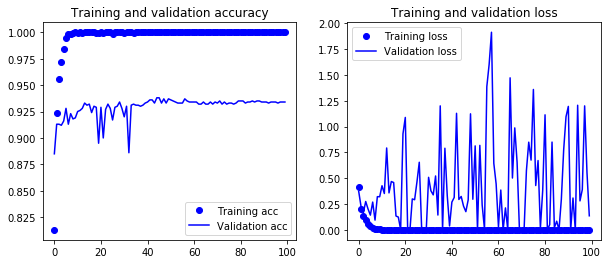

In [56]:
# 居于1的过拟合 太狠
plot_acc_loss(history5)

In [57]:
model5.save('D://tmp//models//cats_and_dogs_small_5.h5')
print(model5.metrics_names)
print(model5.evaluate_generator(test_generator, steps=50))

['loss', 'acc']
[1.8584696054458618, 0.9240000247955322]


## 可视化卷积网络

### 可视化网络中每一层的激活效果

In [81]:
from keras.models import load_model

model = load_model('D://tmp//models//cats_and_dogs_small_1.h5')
model.summary()  # As a reminder.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

(1, 150, 150, 3)


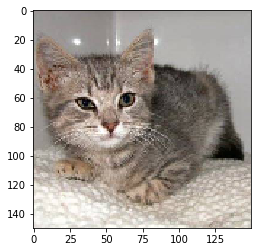

In [59]:
# 加载一张测试图片
img_path = 'D://Kaggle//cat-dog-small//test/cats//cat.1574.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [60]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
# 所以每一层都是以原始图像为输入咯
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [82]:
model.input

<tf.Tensor 'conv2d_4_input:0' shape=(None, 150, 150, 3) dtype=float32>

In [61]:
model.layers[:8]

In [62]:
layer_outputs

[<tf.Tensor 'conv2d_4_1/Relu:0' shape=(None, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_3_1/MaxPool:0' shape=(None, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'conv2d_5_1/Relu:0' shape=(None, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_4_1/MaxPool:0' shape=(None, 36, 36, 64) dtype=float32>,
 <tf.Tensor 'conv2d_6_1/Relu:0' shape=(None, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_5_1/MaxPool:0' shape=(None, 17, 17, 128) dtype=float32>,
 <tf.Tensor 'conv2d_7_1/Relu:0' shape=(None, 15, 15, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_6_1/MaxPool:0' shape=(None, 7, 7, 128) dtype=float32>]

(1, 148, 148, 32)


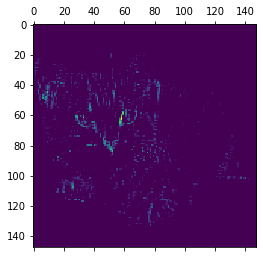

In [63]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

通过将所有的层show出来会发现，随着层越深表示识别的就越抽象

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


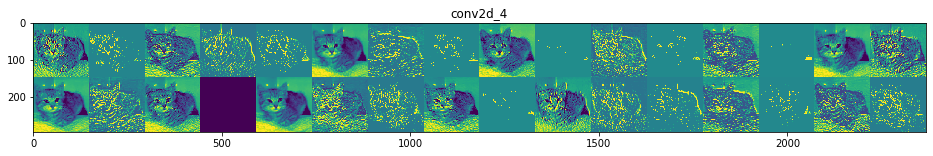

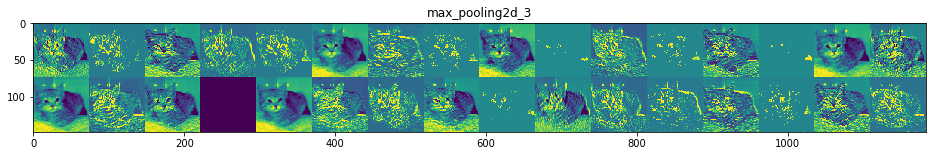

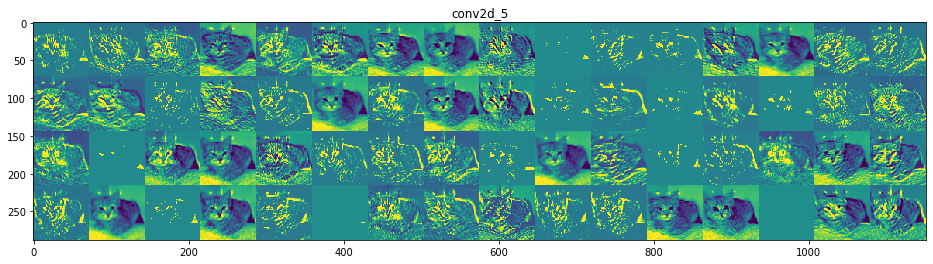

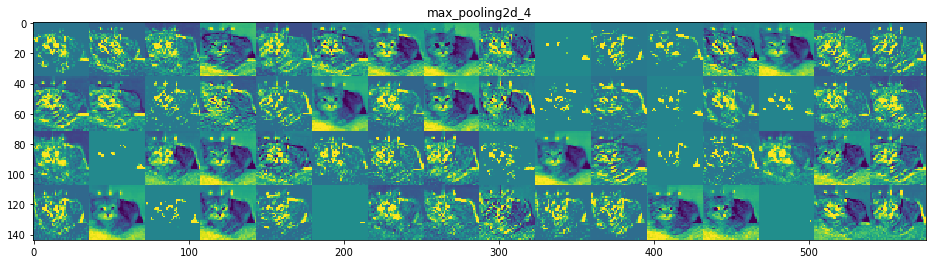

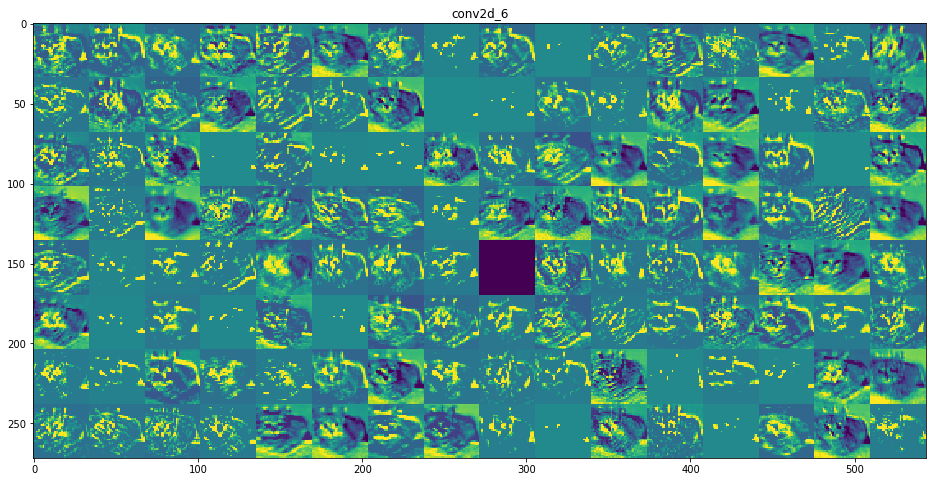

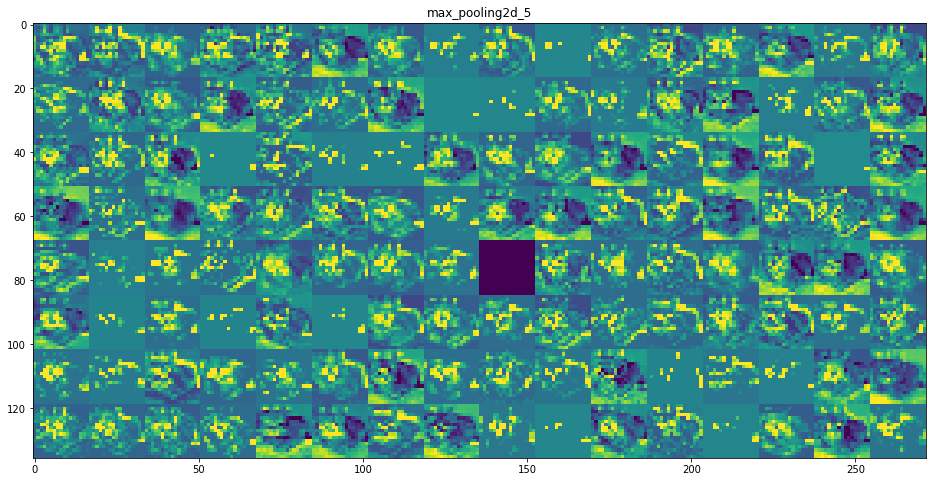

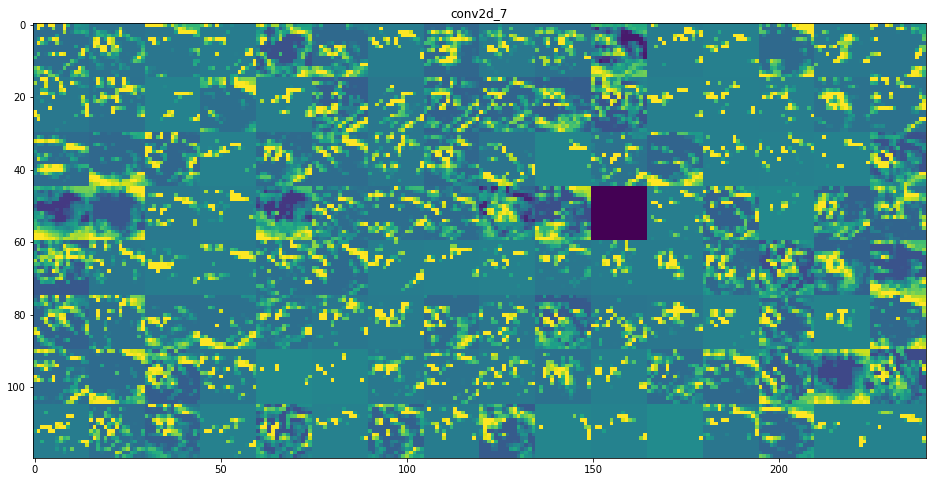

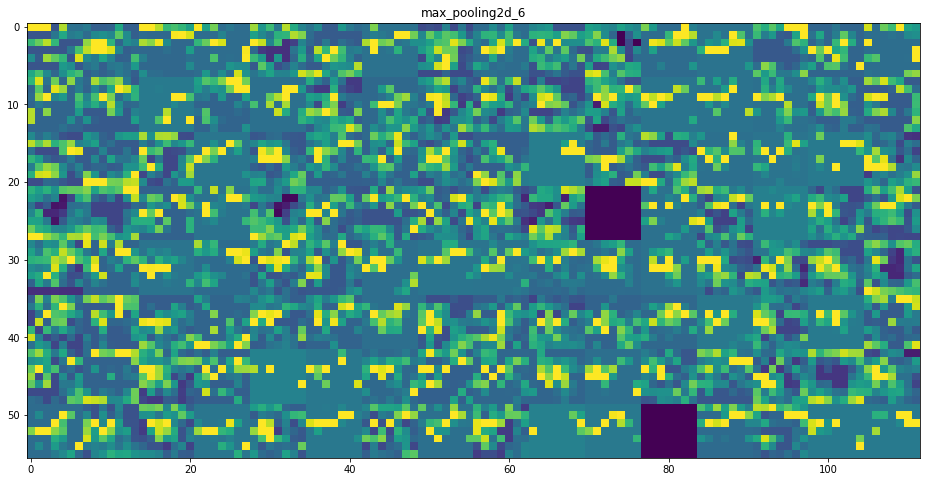

In [64]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

# 一行16张图片
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # 每一层都会有n_features张图片
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row 
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

### 可视化过滤器

In [127]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
layer_output = model.get_layer(layer_name).output
layer_output

<tf.Tensor 'block3_conv1_2/Relu:0' shape=(None, None, None, 256) dtype=float32>

In [128]:
filter_index = 0
loss = K.mean(layer_output[:, :, :, filter_index])
loss

<tf.Tensor 'Mean_9:0' shape=() dtype=float32>

In [129]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

In [130]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [131]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [132]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [133]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [134]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

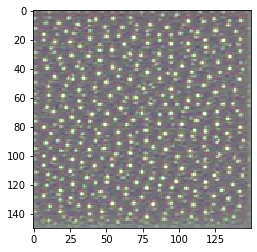

In [135]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


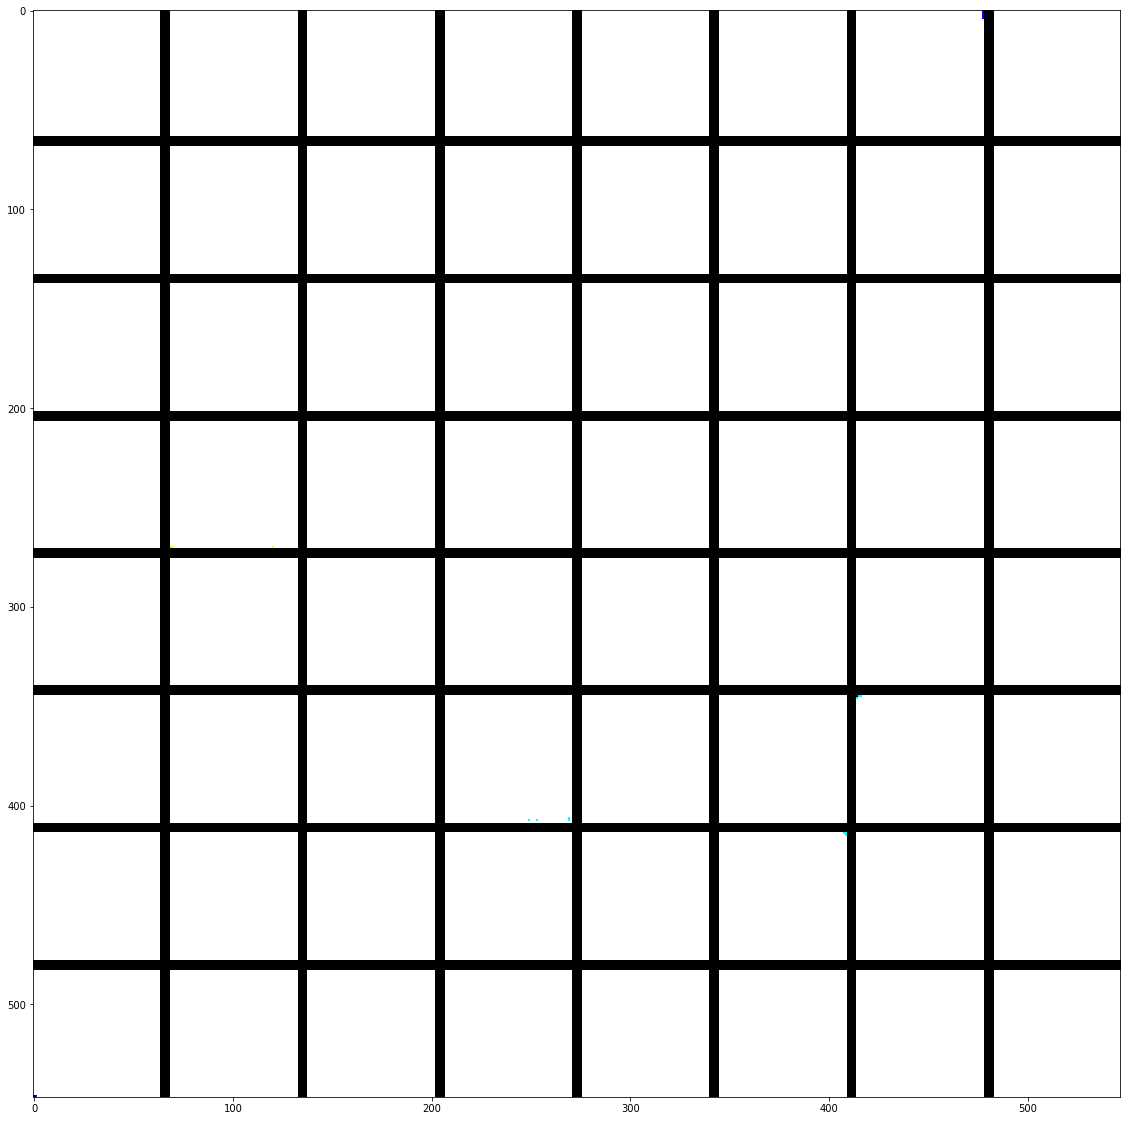

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


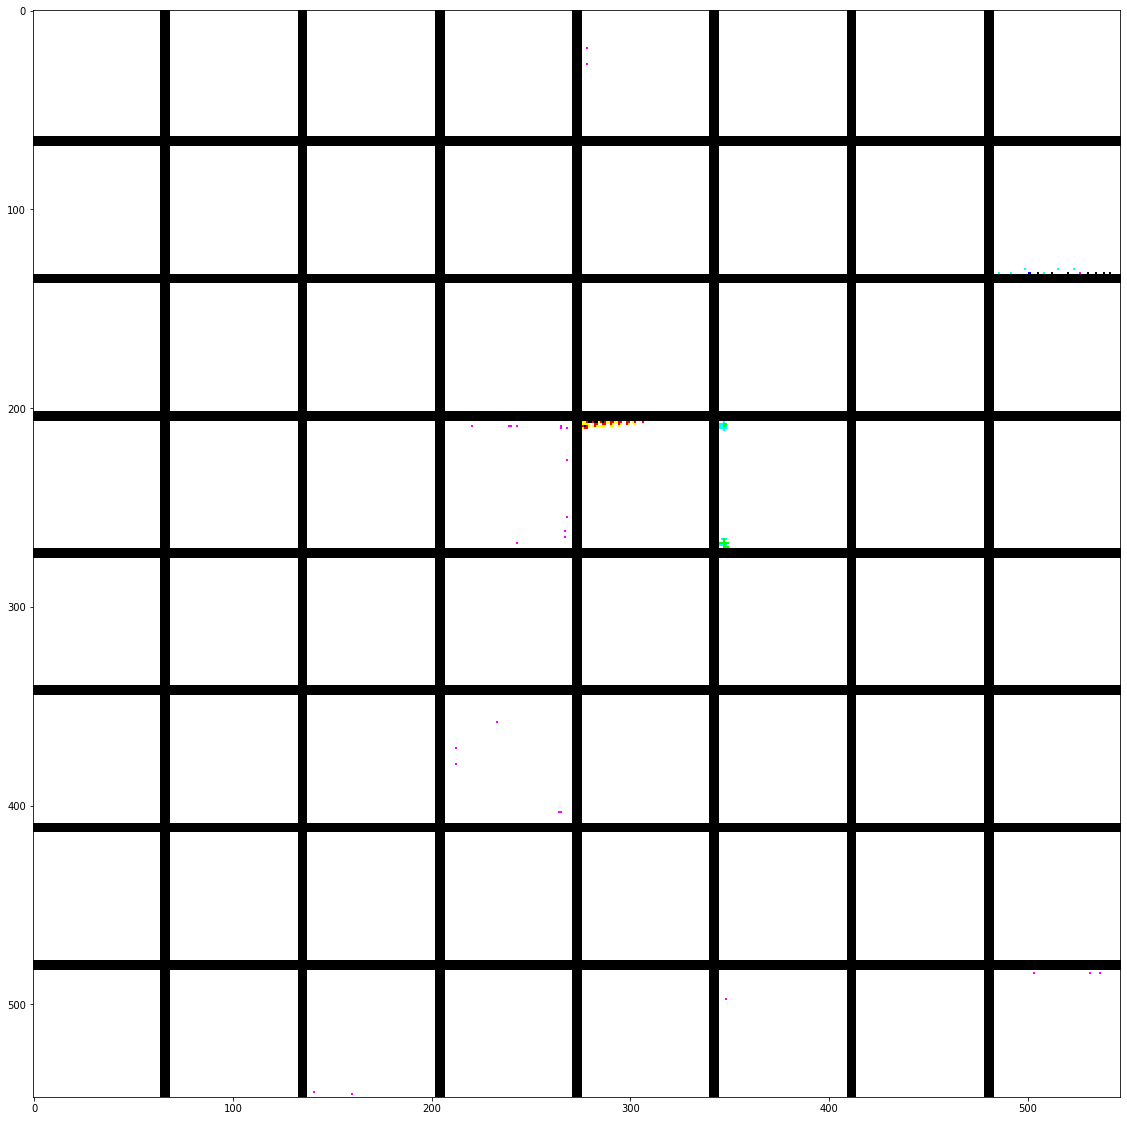

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


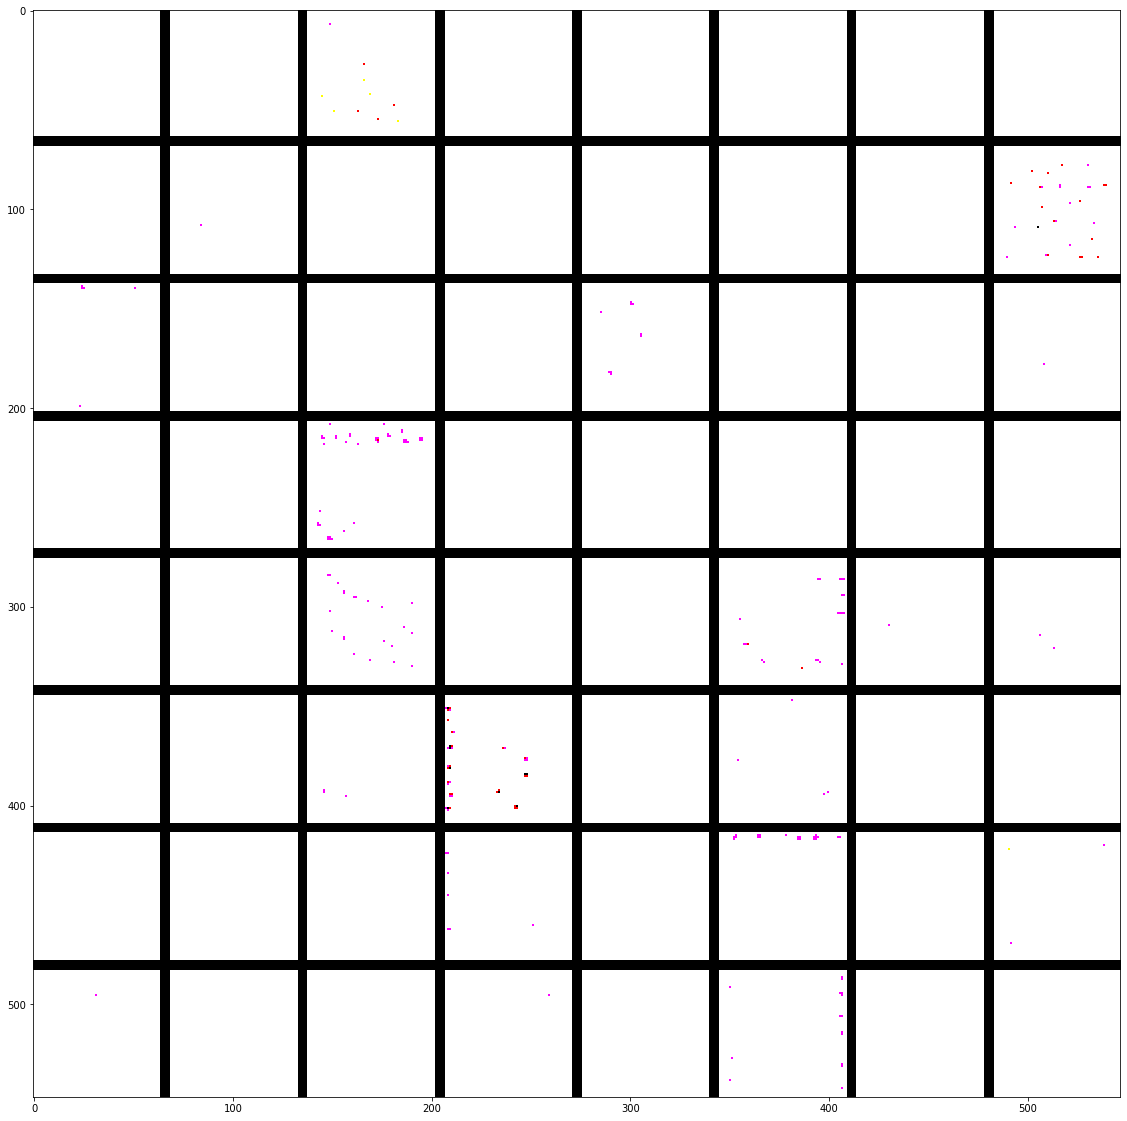

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


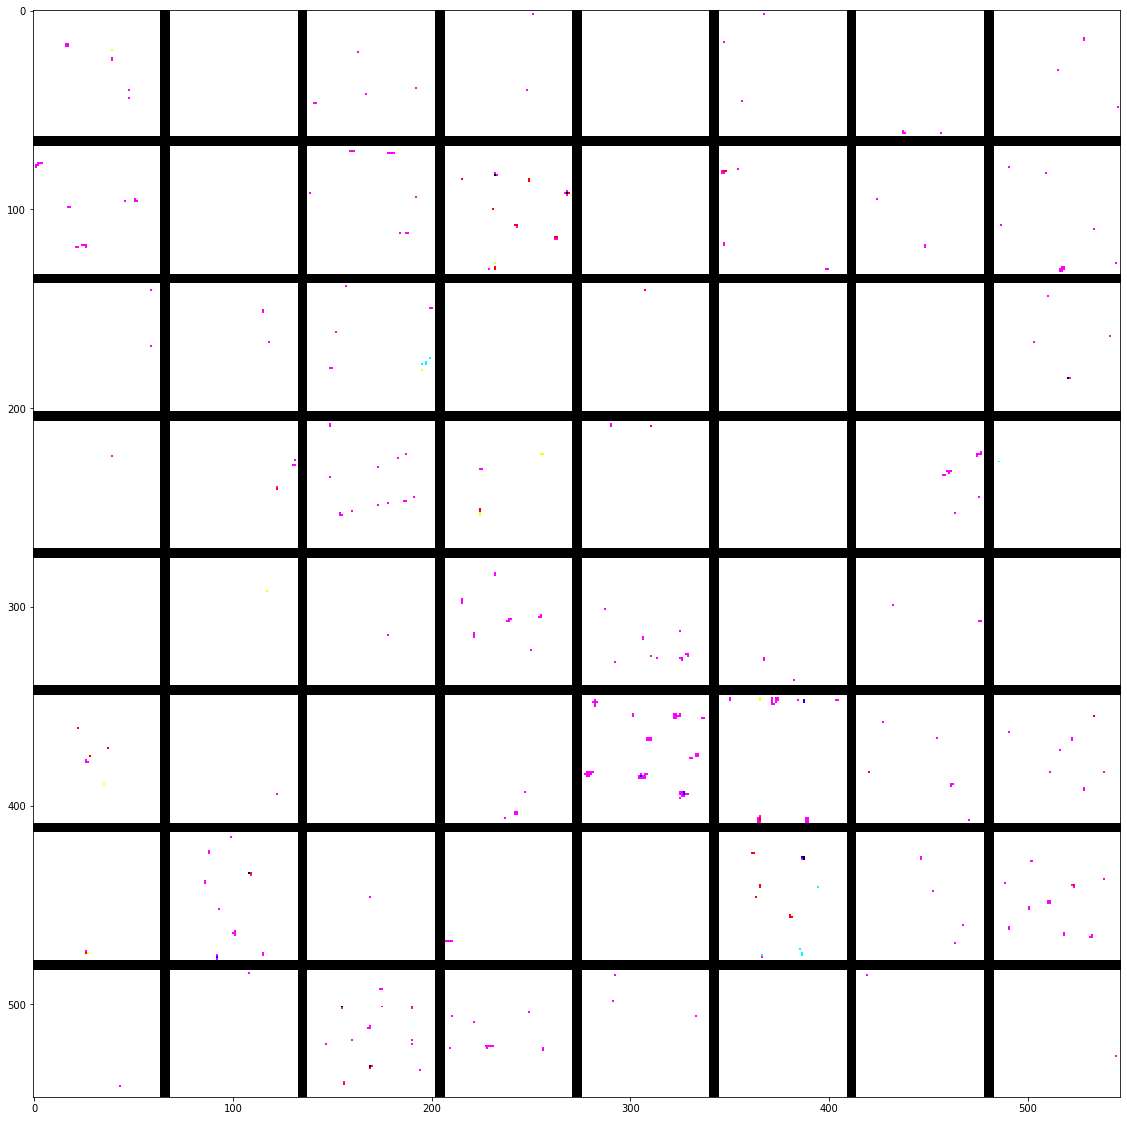

In [136]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

### 可视化激活的热力图  
通过热力图我们可以直观的看到CNN是根据原始图像的哪一部分进行分类的  
画热力图的方法是，使用“每个通道对类别的重要程度”对“输入图像对不同通道的激活强度”的空间图进行加权，从而得到了“输入图像对类别的激活强度”的空间图

In [65]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
# 如果你希望你编写的Keras模块与Theano(th)和TensorFlow(tf)兼容，
# 则必须通过抽象Keras后端API来编写
K.clear_session()

# 加载完整的VGG16模型
# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

In [66]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = 'D:\\tmp\\creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# 将进行颜色标准化
x = preprocess_input(x)

In [68]:
# 预测，并打印TOP3的分类
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.909421), ('n01871265', 'tusker', 0.086182885), ('n02504013', 'Indian_elephant', 0.0043545826)]


In [69]:
# 第386号是非洲象咯
print(preds.shape, np.argmax(preds[0]))

(1, 1000) 386


In [70]:
model.output

<tf.Tensor 'predictions/Softmax:0' shape=(None, 1000) dtype=float32>

In [71]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

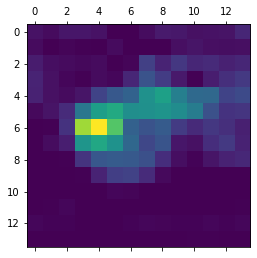

In [72]:
# 标准化
heatmap = np.maximum(heatmap, 0) # 小于0则设成0
heatmap /= np.max(heatmap) # 除最大值
plt.matshow(heatmap)
plt.show()

In [78]:
# 使用OpenCV来将热力图与原图叠加
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('D:\\tmp\\elephant_cam.jpg', superimposed_img)

In [79]:
superimposed_img

array([[[299.6, 214. , 196. ],
        [298.6, 213. , 195. ],
        [298.6, 213. , 195. ],
        ...,
        [274.4, 201. , 188. ],
        [274.4, 201. , 188. ],
        [274.4, 201. , 188. ]],

       [[299.6, 214. , 196. ],
        [299.6, 214. , 196. ],
        [298.6, 213. , 195. ],
        ...,
        [273.4, 200. , 187. ],
        [273.4, 200. , 187. ],
        [273.4, 200. , 187. ]],

       [[299.6, 214. , 196. ],
        [299.6, 214. , 196. ],
        [298.6, 213. , 195. ],
        ...,
        [273.4, 200. , 187. ],
        [273.4, 200. , 187. ],
        [273.4, 200. , 187. ]],

       ...,

       [[173.2, 151. , 142. ],
        [132.2, 110. , 101. ],
        [121.2, 102. ,  91. ],
        ...,
        [131.2,  96. ,  91. ],
        [160.2, 125. , 120. ],
        [155.2, 120. , 115. ]],

       [[141.2, 121. , 112. ],
        [119.2, 100. ,  89. ],
        [142.2, 123. , 112. ],
        ...,
        [150.2, 115. , 110. ],
        [156.2, 121. , 116. ],
        [137.2,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


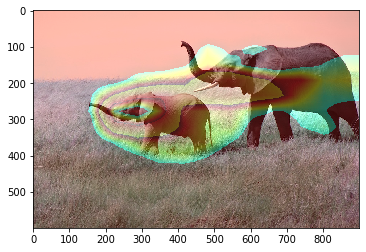

In [80]:
plt.imshow(superimposed_img/300)
plt.show()

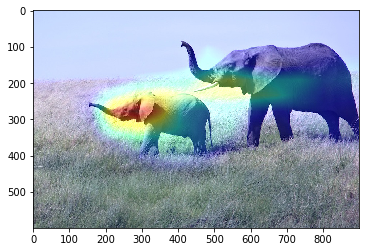

In [153]:
plt.imshow(image.load_img('D:\\tmp\\elephant_cam.jpg'))
plt.show()